## Initial setup

In [ ]:
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate transformers ftfy

In [2]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Settings for teaching your new concept

In [3]:
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2-1-base"

### Get the training images:

#### Download the images from the internet and save them locally.

You can also upload the images to colab or load from google drive, please check the next section if you want to use that.

####  Setup and check the images you have just added

## Teach the model a new concept (fine-tuning with textual inversion)
Execute this this sequence of cells to run the training process. The whole process may take from 1-4 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

In [4]:
what_to_teach = "object"
placeholder_token = "<object1>"
placeholder_token = "$"
initializer_token = "object"

### Create Dataset

In [5]:
#@title Setup the prompt templates for training
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [6]:
print(os.listdir("pseudosketches"))

['n03147509', 'n02437136', 'n02346627', 'n02395406', 'n03590841', 'n01674464', 'n07753592', 'n02330245', 'n03395514', 'n02121620', 'n07745940', 'n11660300', 'n07873807', 'n04576002', 'n02219486', 'n02859184', 'n04389033', 'n04233124', 'n02503517', 'n03481172', 'n02439033', 'n02131653', 'n07739125', 'n03271574', 'n02374451', 'n04099429', 'n02355227', 'n01978930', 'n03948459', 'n02514041', 'n07684084', 'n02895154', 'n03930630', 'n02206856', 'n02932400', 'n01877134', 'n01498041', 'n01639765', 'n02749479', 'n04128499', 'n04507155', 'n02077923', 'n02948072', 'n01819313', 'n04399382', 'n02068974', 'n02391994', 'n02691156', 'n01791625', 'n02480495', 'n01858441', 'n04587559', 'n02169497', 'n03452741', 'n02764044', 'n07768230', 'n02430045', 'n04379243', 'n01846331', 'n09472597', 'n04256520', 'n01669191', 'n01770393', 'n03028079', 'n02041246', 'n01726692', 'n04597913', 'n01621127', 'n07753275', 'n03495258', 'n02980441', 'n03891251', 'n04536866', 'n07697313', 'n02694662', 'n03790512', 'n02676566'

In [7]:
#@title Setup the dataset
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="$",
        center_crop=True,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.class_list = os.listdir(data_root)
        self.image_paths = []
        self.image_nums = []
        self.num_images = 0
        for class_n in self.class_list:
            class_path = os.path.join(self.data_root, class_n)
            self.image_paths.append([os.path.join(class_path, file_path) for file_path in os.listdir(class_path)])
            self.num_images += len(self.image_paths[-1])
            self.image_nums.append(len(self.image_paths[-1]))

        self._length = len(self.class_list) * 10

        self.interpolation = {
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        class_index = i // 10
        class_img_num = self.image_nums[class_index]
        img_i = random.randint(0, class_img_num-1)
        sketch_img_i = random.randint(0, class_img_num-1)
        image = Image.open(self.image_paths[class_index][img_i].replace("pseudosketches", "pseudosketch_images"))
        sketch_img = Image.open(self.image_paths[class_index][sketch_img_i]).convert("RGB")

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = " $" * 8
        text = random.choice(self.templates).format(placeholder_string)
        example["input_text"] = text

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        sketch_img = np.array(sketch_img).astype(np.uint8)

        if self.center_crop:
            crop = min(sketch_img.shape[0], sketch_img.shape[1])
            h, w, = (
                sketch_img.shape[0],
                sketch_img.shape[1],
            )
            sketch_img = sketch_img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]
        sketch_image = Image.fromarray(sketch_img)
        sketch_image = sketch_image.resize((224, 224), resample=self.interpolation)

        sketch_image = self.flip_transform(sketch_image)
        sketch_image = np.array(sketch_image).astype(np.uint8)
        sketch_image = (sketch_image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        example["sketch"] = torch.from_numpy(sketch_image)
        return example

### Setting up the model

In [8]:
#@title Load the tokenizer and add the placeholder token as a additional special token.
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

In [10]:
#@title Load the Stable Diffusion model
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

We have added the `placeholder_token` in the `tokenizer` so we resize the token embeddings here, this will a new embedding vector in the token embeddings for our `placeholder_token`

In [11]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49408, 1024)

 Initialise the newly added placeholder token with the embeddings of the initializer token

In Textual-Inversion we only train the newly added embedding vector, so lets freeze rest of the model parameters here

In [12]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

### Creating our training data

Let's create the Dataset and Dataloader

In [13]:
train_dataset = TextualInversionDataset(
      data_root="dataset/pseudosketches",
      tokenizer=tokenizer,
      size=512,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=True,
      set="train",
)

In [14]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

### check dataloader

In [15]:
print(len(train_dataset))

1250


In [16]:
reverse_transform = transforms.ToPILImage()

In [17]:
print(train_dataset[0]["sketch"].shape)

torch.Size([224, 224, 3])


In [18]:
print(train_dataset[0]["pixel_values"].shape)

torch.Size([3, 512, 512])


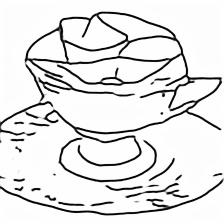

In [19]:
display(reverse_transform(train_dataset[5]["sketch"].permute(2, 0, 1) * 0.5 + 0.5))

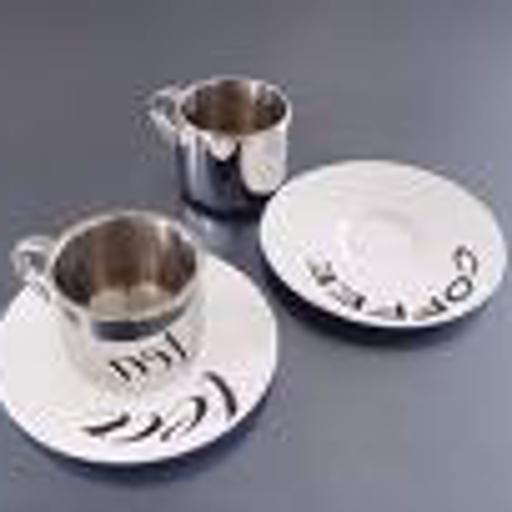

In [20]:
display(reverse_transform(train_dataset[5]["pixel_values"] * 0.5 + 0.5))

Create noise_scheduler for training

In [21]:
noise_scheduler = DDPMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

/home/chiang/miniconda3/envs/CG/lib/python3.11/site-packages/diffusers/configuration_utils.py:196: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [22]:
import torch.nn as nn
from transformers.models.clip.modeling_clip import CLIPEncoderLayer


class InversionAdapter(nn.Module):
    def __init__(self, input_dim: int, hidden_dim:int, output_dim, config, num_encoder_layers, dropout=0.5):
        super().__init__()
        self.config = config
        self.encoder_layers = nn.ModuleList([CLIPEncoderLayer(config) for _ in range(num_encoder_layers)])
        self.post_layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, None, None)
            x = x[0]
        x = x[:, 0, :]
        x = self.post_layernorm(x)
        return self.layers(x)

In [23]:
import torch
from transformers import CLIPTextModel
from transformers.modeling_outputs import BaseModelOutputWithPooling


def encode_text_word_embedding(text_encoder: CLIPTextModel, input_ids: torch.tensor, word_embeddings: torch.tensor,
                               num_vstar: int = 1) -> BaseModelOutputWithPooling:
    """
    Encode text by replacing the '$' with the PTEs extracted with the inversion adapter.
    Heavily based on hugginface implementation of CLIP.
    """
    existing_indexes = (input_ids == 259).nonzero(as_tuple=True)[0]  # 259 is the index of '$' in the vocabulary
    existing_indexes = existing_indexes.unique()
    if len(existing_indexes) > 0:  # if there are '$' in the text
        _, counts = torch.unique((input_ids == 259).nonzero(as_tuple=True)[0], return_counts=True)
        cum_sum = torch.cat((torch.zeros(1, device=input_ids.device).int(), torch.cumsum(counts, dim=0)[:-1]))
        first_vstar_indexes = (input_ids == 259).nonzero()[cum_sum][:,
                              1]  # get the index of the first '$' in each sentence
        rep_idx = torch.cat([(first_vstar_indexes + n).unsqueeze(0) for n in range(num_vstar)])
        word_embeddings = word_embeddings.to(input_ids.device)

    input_shape = input_ids.size()
    input_ids = input_ids.view(-1, input_shape[-1])

    seq_length = input_ids.shape[-1]
    position_ids = text_encoder.text_model.embeddings.position_ids[:, :seq_length]
    input_embeds = text_encoder.text_model.embeddings.token_embedding(input_ids)

    if len(existing_indexes) > 0:
        assert word_embeddings.shape[0] == input_embeds.shape[0]
        if len(word_embeddings.shape) == 2:
            word_embeddings = word_embeddings.unsqueeze(1)
        input_embeds[torch.arange(input_embeds.shape[0]).repeat_interleave(
            num_vstar).reshape(input_embeds.shape[0], num_vstar)[existing_indexes.cpu()], rep_idx.T] = \
            word_embeddings.to(input_embeds.dtype)[existing_indexes]  # replace the '$' with the PTEs

    position_embeddings = text_encoder.text_model.embeddings.position_embedding(position_ids)
    hidden_states = input_embeds + position_embeddings

    bsz, seq_len = input_shape
    # CLIP's text model uses causal mask, prepare it here.
    # https://github.com/openai/CLIP/blob/cfcffb90e69f37bf2ff1e988237a0fbe41f33c04/clip/model.py#L324
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, hidden_states.dtype).to(
        hidden_states.device
    )

    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=hidden_states,
        attention_mask=None,
        causal_attention_mask=causal_attention_mask,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    )

    last_hidden_state = encoder_outputs[0]
    last_hidden_state = text_encoder.text_model.final_layer_norm(last_hidden_state)

    pooled_output = last_hidden_state[
        torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
        input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
    ]

    return BaseModelOutputWithPooling(
        last_hidden_state=last_hidden_state,
        pooler_output=pooled_output,
        hidden_states=encoder_outputs.hidden_states,
        attentions=encoder_outputs.attentions,
    )

In [24]:
print(text_encoder.config.hidden_size)

1024


In [25]:
from transformers import CLIPVisionModelWithProjection, AutoProcessor

### Training

Define hyperparameters for our training
If you are not happy with your results, you can tune the `learning_rate` and the `max_train_steps`

In [26]:
#@title Setting up all training args
hyperparameters = {
    "learning_rate": 1e-05,
    "scale_lr": False,
    "max_train_steps": 20000,
    "save_steps": 2000,
    "val_steps": 1000,
    "train_batch_size": 8,
    "accu_iter": 2,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-concept-output",
    "save_path": "inversion0110"
}
!mkdir -p sd-concept-output

Train!

In [27]:
save_path = "checkpoints"

In [35]:
#@title Training function
import logging
logging.basicConfig(filename='train_encoder.log', encoding='utf-8', level=logging.INFO)
logger = get_logger(__name__)

def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)

def training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]
    save_path = hyperparameters["save_path"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    vision_encoder = CLIPVisionModelWithProjection.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")
    # processor = AutoProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")
    inversion_adapter = InversionAdapter(input_dim=vision_encoder.config.hidden_size,
        hidden_dim=vision_encoder.config.hidden_size * 4,
        output_dim=1024 * 8,
        num_encoder_layers=1,
        config=vision_encoder.config).to(accelerator.device)
    # if checkpoints
    # ckpt = torch.load("checkpoints/inversion0110/inversion_4000.pt")
    # inversion_adapter.load_state_dict(ckpt)

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        inversion_adapter.parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )

    inversion_adapter, text_encoder, optimizer, train_dataloader = accelerator.prepare(
        inversion_adapter, text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)
    vision_encoder.to(accelerator.device, dtype=weight_dtype)
    # inversion_adapter

    # Keep vae in eval mode as we don't train it
    vae.eval()
    vision_encoder.requires_grad_(False)
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()
    inversion_adapter.train()


    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 20000
    total_loss = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        total_loss = 0
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # sketches = ((batch["sketch"] + 1) / 2).clamp(0, 1)

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                # encoder_hidden_states = text_encoder(batch["input_ids"])[0]
                tokenized_text = tokenizer(batch["input_text"], max_length=tokenizer.model_max_length, padding="max_length",
                                           truncation=True, return_tensors="pt").input_ids.to(accelerator.device)
                # tokenized_text = batch["input_ids"].to(accelerator.device)

                # processed_images = processor(images=batch["sketch"], return_tensors="pt")
                clip_features = vision_encoder(
                    batch["sketch"].permute(0, 3, 1, 2).to(accelerator.device).to(weight_dtype)).last_hidden_state
                word_embeddings = inversion_adapter(clip_features.to(accelerator.device))
                word_embeddings = word_embeddings.reshape((bsz, 8, -1))
                encoder_hidden_states = encode_text_word_embedding(text_encoder, tokenized_text,
                                                                   word_embeddings,
                                                                   num_vstar=8).last_hidden_state.to(weight_dtype)
                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                 # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                with accelerator.autocast():
                    loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                    total_loss += loss.item()

                accelerator.backward(loss)

                if global_step % hyperparameters["accu_iter"] == 0:
                    optimizer.step()
                    optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    torch.save(inversion_adapter.state_dict(), os.path.join("checkpoints", save_path, f"inversion_{global_step}.pt"))
                if global_step % hyperparameters["val_steps"] == 1:
                    with torch.no_grad():
                        pipeline = StableDiffusionPipeline.from_pretrained(
                            pretrained_model_name_or_path,
                            text_encoder=accelerator.unwrap_model(text_encoder),
                            tokenizer=tokenizer,
                            vae=vae,
                            unet=unet,
                        )

                        num_samples = 8
                        num_rows = 1
                        resize_img = transforms.Resize((512, 512))
                        with torch.cuda.amp.autocast():
                            all_images = [reverse_transform(batch["pixel_values"][i] * 0.5 + 0.5) for i in range(bsz)]
                            all_images.extend([resize_img(reverse_transform(batch["sketch"][i].permute(2, 0, 1) * 0.5 + 0.5)) for i in range(bsz)])
                            for _ in range(num_rows):
                                images = pipeline(prompt_embeds=encoder_hidden_states, num_inference_steps=30, guidance_scale=7.5).images
                                all_images.extend(images)
                            grid = image_grid(all_images, num_rows+2, num_samples)
                            grid.save(os.path.join("sample", save_path, f"step_{global_step}.jpg"))
                            

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break
        logger.info(f"[epoch {epoch}] loss: {total_loss/len(train_dataloader):.6f}")
        print(f"[epoch {epoch}] loss: {total_loss/len(train_dataloader):.6f}")
        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)

        torch.save(inversion_adapter, os.path.join("checkpoints", save_path, f"inversion_last.pt"))

In [36]:
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet), num_processes=1)

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

Launching training on one GPU.


Some weights of the model checkpoint at laion/CLIP-ViT-H-14-laion2B-s32B-b79K were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.10.self_attn.out_proj.weight', 'text_model.encoder.layers.3.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.encoder.layers.2.layer_norm1.bias', 'text_model.encoder.layers.3.self_attn.k_proj.weight', 'text_model.encoder.layers.5.layer_norm2.bias', 'text_model.encoder.layers.16.self_attn.q_proj.bias', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.22.mlp.fc2.bias', 'text_model.encoder.layers.12.self_attn.k_proj.bias', 'text_model.encoder.layers.9.self_attn.out_proj.bias', 'text_model.encoder.layers.8.mlp.fc2.bias', 'text_model.encoder.layers.12.self_attn.k_proj.weight', 'text_model.encoder.layers.11.layer_norm2.bias', 'text_model.encoder.layers.14.mlp.fc1.bias', 'text_model.encoder.layers.19.self_attn.v_proj.bias', 'text_model.encoder.layers.11.self_attn

  0%|          | 0/20000 [00:00<?, ?it/s]

/home/chiang/miniconda3/envs/CG/lib/python3.11/site-packages/diffusers/schedulers/scheduling_ddpm.py:172: FutureWarning: Accessing `num_train_timesteps` directly via scheduler.num_train_timesteps is deprecated. Please use `scheduler.config.num_train_timesteps instead`
  deprecate(
/home/chiang/miniconda3/envs/CG/lib/python3.11/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/30 [00:00<?, ?it/s]

[epoch 0] loss: 0.001928
[epoch 1] loss: 0.001131
[epoch 2] loss: 0.001192
[epoch 3] loss: 0.001108
[epoch 4] loss: 0.000361
[epoch 5] loss: 0.000890
[epoch 6] loss: 0.000760
[epoch 7] loss: 0.001123
[epoch 8] loss: 0.000358
[epoch 9] loss: 0.000564
[epoch 10] loss: 0.002217


KeyboardInterrupt: 